In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from matplotlib.gridspec import GridSpec

# Settings

In [ ]:
# --- Settings & Pathing ---
DATA_FOLDER = "./data_sources/2025-11/" 
RESAMPLE_RULE = "1min"

# Data Loading

In [28]:
# --- Scalable Data Loading (The Batch Loader) ---
def load_fleet_data(folder_path):
    """Finds all CSVs in a folder and combines them into a Fleet DataFrame, preserving all columns."""
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not all_files:
        raise FileNotFoundError(f"No CSV files found in {folder_path}")
        
    fleet_list = []
    print(f"Loading {len(all_files)} chargers...")
    
    for file in all_files:
        # Load and parse
        df_raw = pd.read_csv(file)
        df_raw["dateTime"] = pd.to_datetime(df_raw["dateTime"], format="ISO8601", errors="coerce")
        df_raw = df_raw.dropna(subset=["dateTime"]).sort_values("dateTime").set_index("dateTime")
        
        # Metadata extraction
        charger_id = df_raw['systemId'].iloc[0] if 'systemId' in df_raw.columns else "Unknown"
        
        # --- 1. Define Aggregation Logic for ALL Columns ---
        # Power/Flow columns (Mean)
        power_cols = ['charger_kw', 'v2g_kw', 'v2h_kw', 'g2v_kw', 'h2v_kw', 'solar_kw', 'consumption_kw', 'grid_kw']
        # State/Price columns (Last known value)
        state_cols = ['soc_percent', 'import_price_kwh', 'export_price_kwh', 'target_soc', 'charger_status']
        # Metadata columns (Fixed values)
        meta_cols = ['ev_battery_kwh', 'max_charge_kw', 'max_discharge_kw', 'min_soc', 'max_soc', 'is_smart_charge', 'command']

        cols_to_agg = {}
        for c in power_cols: cols_to_agg[c] = 'mean'
        for c in state_cols: cols_to_agg[c] = 'last'
        for c in meta_cols:  cols_to_agg[c] = 'first'

        # Filter for only those columns actually present in the CSV
        existing_agg = {k: v for k, v in cols_to_agg.items() if k in df_raw.columns}
        
        # --- 2. Resample and Handle Gaps ---
        df_res = df_raw.resample(RESAMPLE_RULE).agg(existing_agg)
        
        # Fill power with 0 (idle)
        for c in power_cols:
            if c in df_res.columns: df_res[c] = df_res[c].fillna(0)
            
        # Fill states/metadata with Forward Fill (keep last known battery level/price/status)
        other_cols = [c for c in df_res.columns if c not in power_cols]
        df_res[other_cols] = df_res[other_cols].ffill().bfill()
        
        df_res['systemId'] = charger_id
        fleet_list.append(df_res)
        
    # Combine all
    df_fleet = pd.concat(fleet_list)
    
    # Add Time-based features
    df_fleet['hour'] = df_fleet.index.hour
    df_fleet['date'] = df_fleet.index.date
    df_fleet['day_type'] = np.where(df_fleet.index.dayofweek >= 5, 'Weekend', 'Weekday')
    
    month_str = df_fleet.index.min().strftime('%B %Y')
    return df_fleet, month_str


In [29]:
# Execute Loading
df, month_str = load_fleet_data(DATA_FOLDER)

# --- 3. Fleet-Wide Aggregations ---
# Calculate the MEAN behavior of the entire fleet
power_cols = ['charger_kw', 'v2g_kw', 'v2h_kw', 'g2v_kw', 'h2v_kw', 'solar_kw', 'consumption_kw']
fleet_avg_profile = df.groupby('hour')[power_cols].mean()
fleet_split_profile = df.groupby(['day_type', 'hour'])[power_cols].mean()

# Calculate the SUM (Total Grid Impact) across the fleet for every minute
fleet_total_impact = df.groupby(df.index)['charger_kw'].sum()

Loading 1 chargers...


# RQ1 How do people use V2G during the trial?

In [30]:
# --- 4. Enhanced Plotting Functions ---

def plot_site_flows(ax, data, title, show_legend=False):
    """Fleet-ready version: plots the 'Average' site context."""
    ax.fill_between(data.index, 0, data['solar_kw'], color='#FFD700', alpha=0.1, label='Fleet Avg Solar')
    ax.plot(data.index, data['consumption_kw'], color='#7f8c8d', linestyle='--', alpha=0.6, label='Fleet Avg House Load')

    # Charging (+ve)
    ax.fill_between(data.index, 0, data['h2v_kw'], label='Charge: Solar (H2V)', color='#2ca02c', alpha=0.8)
    ax.fill_between(data.index, data['h2v_kw'], data['h2v_kw'] + data['g2v_kw'], 
                     label='Charge: Grid (G2V)', color='#1f77b4', alpha=0.8)

    # Discharging (-ve)
    ax.fill_between(data.index, 0, -data['v2h_kw'], label='Discharge: Home (V2H)', color='#ff7f0e', alpha=0.8)
    ax.fill_between(data.index, -data['v2h_kw'], -(data['v2h_kw'] + data['v2g_kw']), 
                     label='Discharge: Grid (V2G)', color='#d62728', alpha=0.8)

    ax.plot(data.index, data['charger_kw'], color='black', linewidth=2, label='Fleet Net Avg', marker='o', markersize=3)
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel("Avg Power (kW)")
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle=':', alpha=0.5)
    if show_legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=10)

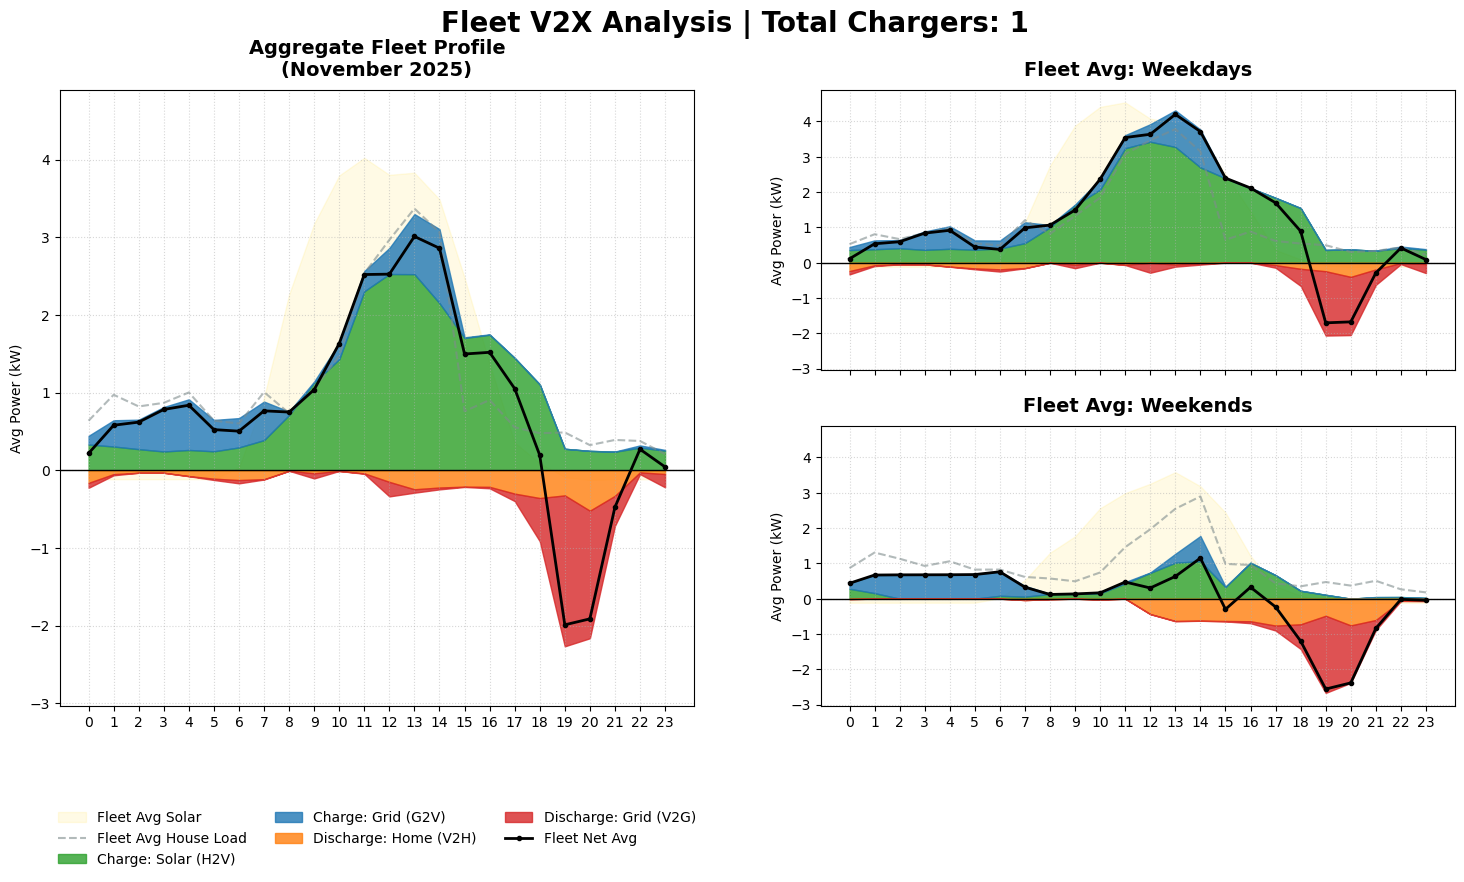

In [31]:
# --- FIGURE 1: FLEET AVERAGE SITE ANALYSIS ---
fig1 = plt.figure(figsize=(18, 8))
gs = fig1.add_gridspec(2, 2)
ax_agg = fig1.add_subplot(gs[:, 0])
ax_wd = fig1.add_subplot(gs[0, 1], sharey=ax_agg)
ax_we = fig1.add_subplot(gs[1, 1], sharey=ax_agg, sharex=ax_wd)

plot_site_flows(ax_agg, fleet_avg_profile, f"Aggregate Fleet Profile\n({month_str})", show_legend=True)
plot_site_flows(ax_wd, fleet_split_profile.loc['Weekday'], "Fleet Avg: Weekdays")
plot_site_flows(ax_we, fleet_split_profile.loc['Weekend'], "Fleet Avg: Weekends")

plt.setp(ax_wd.get_xticklabels(), visible=False)
fig1.suptitle(f"Fleet V2X Analysis | Total Chargers: {df['systemId'].nunique()}", fontsize=20, fontweight='bold', y=0.98)
plt.show()


In [32]:
'''
# --- FIGURE 2: FLEET FINGERPRINT (CHARGER vs HOUR) ---
# Scalable tweak: Row = Charger ID, Column = Hour. Shows diversity of behavior.
plt.figure(figsize=(14, 10))
fleet_heatmap = df.pivot_table(index='systemId', columns='hour', values='charger_kw', aggfunc='mean')
sns.heatmap(fleet_heatmap, cmap="RdBu_r", center=0, cbar_kws={'label': 'Avg Power (kW)'})
plt.title(f"Fleet Fingerprint: Usage Diversity across Chargers\n{month_str}", fontsize=16, fontweight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Charger ID (systemId)")
plt.tight_layout()
plt.show()
'''

'\n# --- FIGURE 2: FLEET FINGERPRINT (CHARGER vs HOUR) ---\n# Scalable tweak: Row = Charger ID, Column = Hour. Shows diversity of behavior.\nplt.figure(figsize=(14, 10))\nfleet_heatmap = df.pivot_table(index=\'systemId\', columns=\'hour\', values=\'charger_kw\', aggfunc=\'mean\')\nsns.heatmap(fleet_heatmap, cmap="RdBu_r", center=0, cbar_kws={\'label\': \'Avg Power (kW)\'})\nplt.title(f"Fleet Fingerprint: Usage Diversity across Chargers\n{month_str}", fontsize=16, fontweight=\'bold\')\nplt.xlabel("Hour of Day")\nplt.ylabel("Charger ID (systemId)")\nplt.tight_layout()\nplt.show()\n'

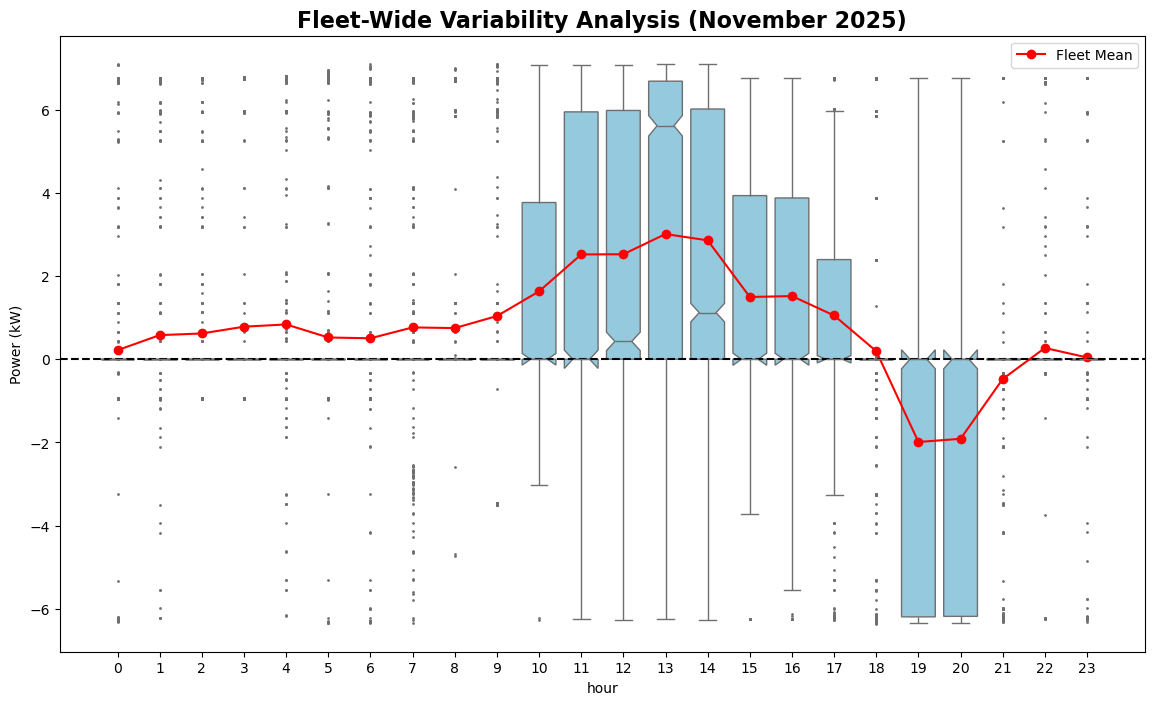

In [33]:

# --- FIGURE 3: FLEET VARIABILITY (BOXPLOT) ---
plt.figure(figsize=(14, 8))
sns.boxplot(x='hour', y='charger_kw', data=df, color='skyblue', fliersize=1, notch=True)
plt.plot(fleet_avg_profile.index, fleet_avg_profile['charger_kw'], color='red', marker='o', label='Fleet Mean')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"Fleet-Wide Variability Analysis ({month_str})", fontsize=16, fontweight='bold')
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

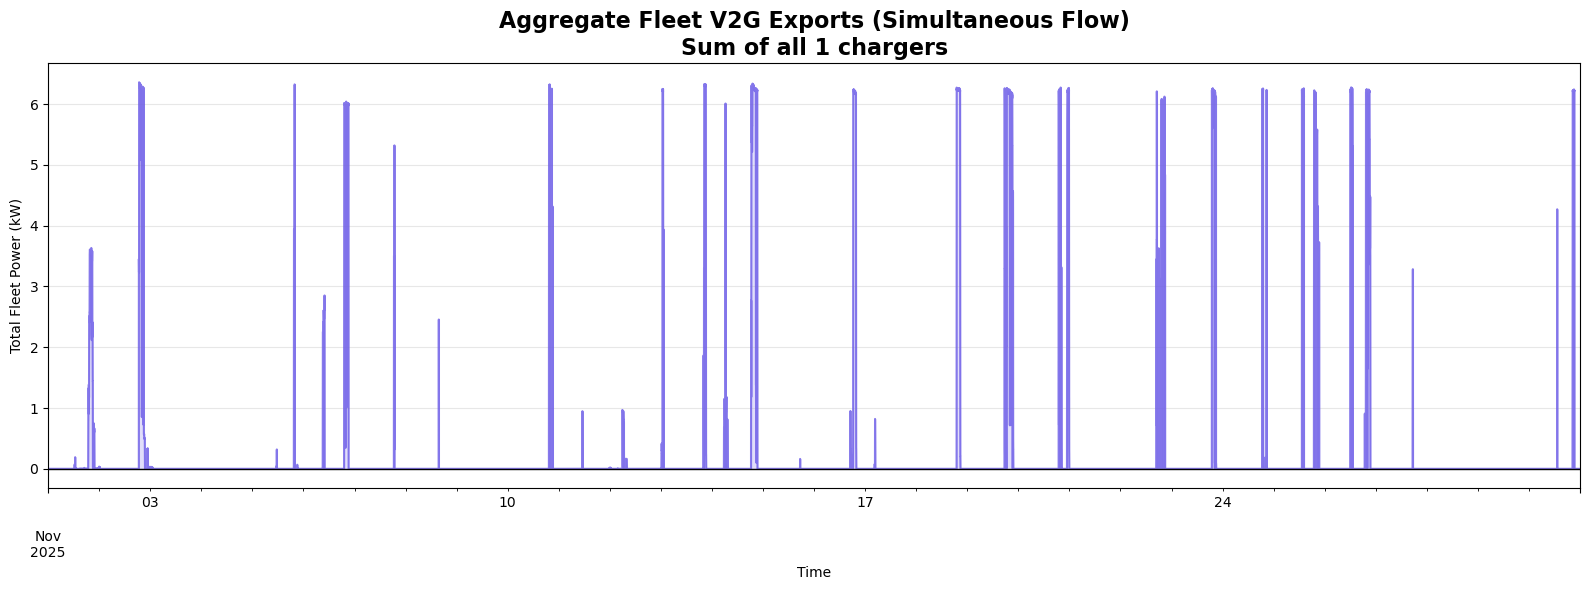

In [34]:
# Calculate the SUM (Total Grid Impact) across the fleet for every minute
fleet_total_v2g = df.groupby(df.index)['v2g_kw'].sum()

# --- FIGURE 4: AGGREGATE GRID IMPACT (TOTAL FLEET KW) ---
# This shows the 'Virtual Power Plant' view
plt.figure(figsize=(16, 6))
fleet_total_v2g.plot(color='#6c5ce7', alpha=0.8)
plt.axhline(0, color='black', linewidth=1)
plt.fill_between(fleet_total_v2g.index, 0, fleet_total_v2g, color='#6c5ce7', alpha=0.2)
plt.title(f"Aggregate Fleet V2G Exports (Simultaneous Flow)\nSum of all {df['systemId'].nunique()} chargers", fontsize=16, fontweight='bold')
plt.ylabel("Total Fleet Power (kW)")
plt.xlabel("Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
def generate_fleet_performance_table(df):
    """Calculates KPIs for each charger and the fleet as a whole."""
    # 1. Group by Charger
    # We use .agg to calculate different metrics for different columns
    charger_stats = df.groupby('systemId').agg({
        'v2g_kw': lambda x: (x.sum() / 60).round(2), # kWh
        'v2h_kw': lambda x: (x.sum() / 60).round(2), # kWh
        'g2v_kw': lambda x: (x.sum() / 60).round(2), # kWh
        'h2v_kw': lambda x: (x.sum() / 60).round(2), # kWh
        'soc_percent': 'mean',
        'charger_kw': [
            ('Peak_kW', lambda x: x.abs().max()),
            ('Utilization_Pct', lambda x: (x != 0).mean() * 100)
        ]
    })

    # Flatten the MultiIndex columns
    charger_stats.columns = [
        'Total_V2G_kWh', 'Total_V2H_kWh', 'Total_G2V_kWh', 
        'Total_H2V_kWh', 'Avg_SoC', 'Peak_kW', 'Utilization_Pct'
    ]

    # 2. Derived Metrics
    charger_stats['Total_V2X_kWh'] = charger_stats['Total_V2G_kWh'] + charger_stats['Total_V2H_kWh']
    
    # 3. Fleet Summary
    fleet_summary = pd.Series({
        'Total Fleet Discharge (MWh)': (charger_stats['Total_V2X_kWh'].sum() / 1000).round(3),
        'Avg Fleet Utilization (%)': charger_stats['Utilization_Pct'].mean().round(2),
        'Avg SoC Across Fleet (%)': charger_stats['Avg_SoC'].mean().round(1),
        'Fleet Solar Self-Consumption (%)': (
            (charger_stats['Total_H2V_kWh'].sum() / 
            (charger_stats['Total_G2V_kWh'].sum() + charger_stats['Total_H2V_kWh'].sum())) * 100
        ).round(2)
    })

    return charger_stats.sort_values('Total_V2X_kWh', ascending=False), fleet_summary

# Usage:
rankings, summary = generate_fleet_performance_table(df)

print("--- FLEET GLOBAL SUMMARY ---")
print(summary)
print("\n--- TOP 5 CHARGERS BY V2X VOLUME ---")
print(rankings.head(5))

--- FLEET GLOBAL SUMMARY ---
Total Fleet Discharge (MWh)          0.271
Avg Fleet Utilization (%)           31.840
Avg SoC Across Fleet (%)            59.400
Fleet Solar Self-Consumption (%)    78.930
dtype: float64

--- TOP 5 CHARGERS BY V2X VOLUME ---
              Total_V2G_kWh  Total_V2H_kWh  Total_G2V_kWh  Total_H2V_kWh  \
systemId                                                                   
SN2507190605         159.48         111.92         179.61          672.9   

                Avg_SoC  Peak_kW  Utilization_Pct  Total_V2X_kWh  
systemId                                                          
SN2507190605  59.397824    7.107        31.844907          271.4  


## Playing with an alternative viz

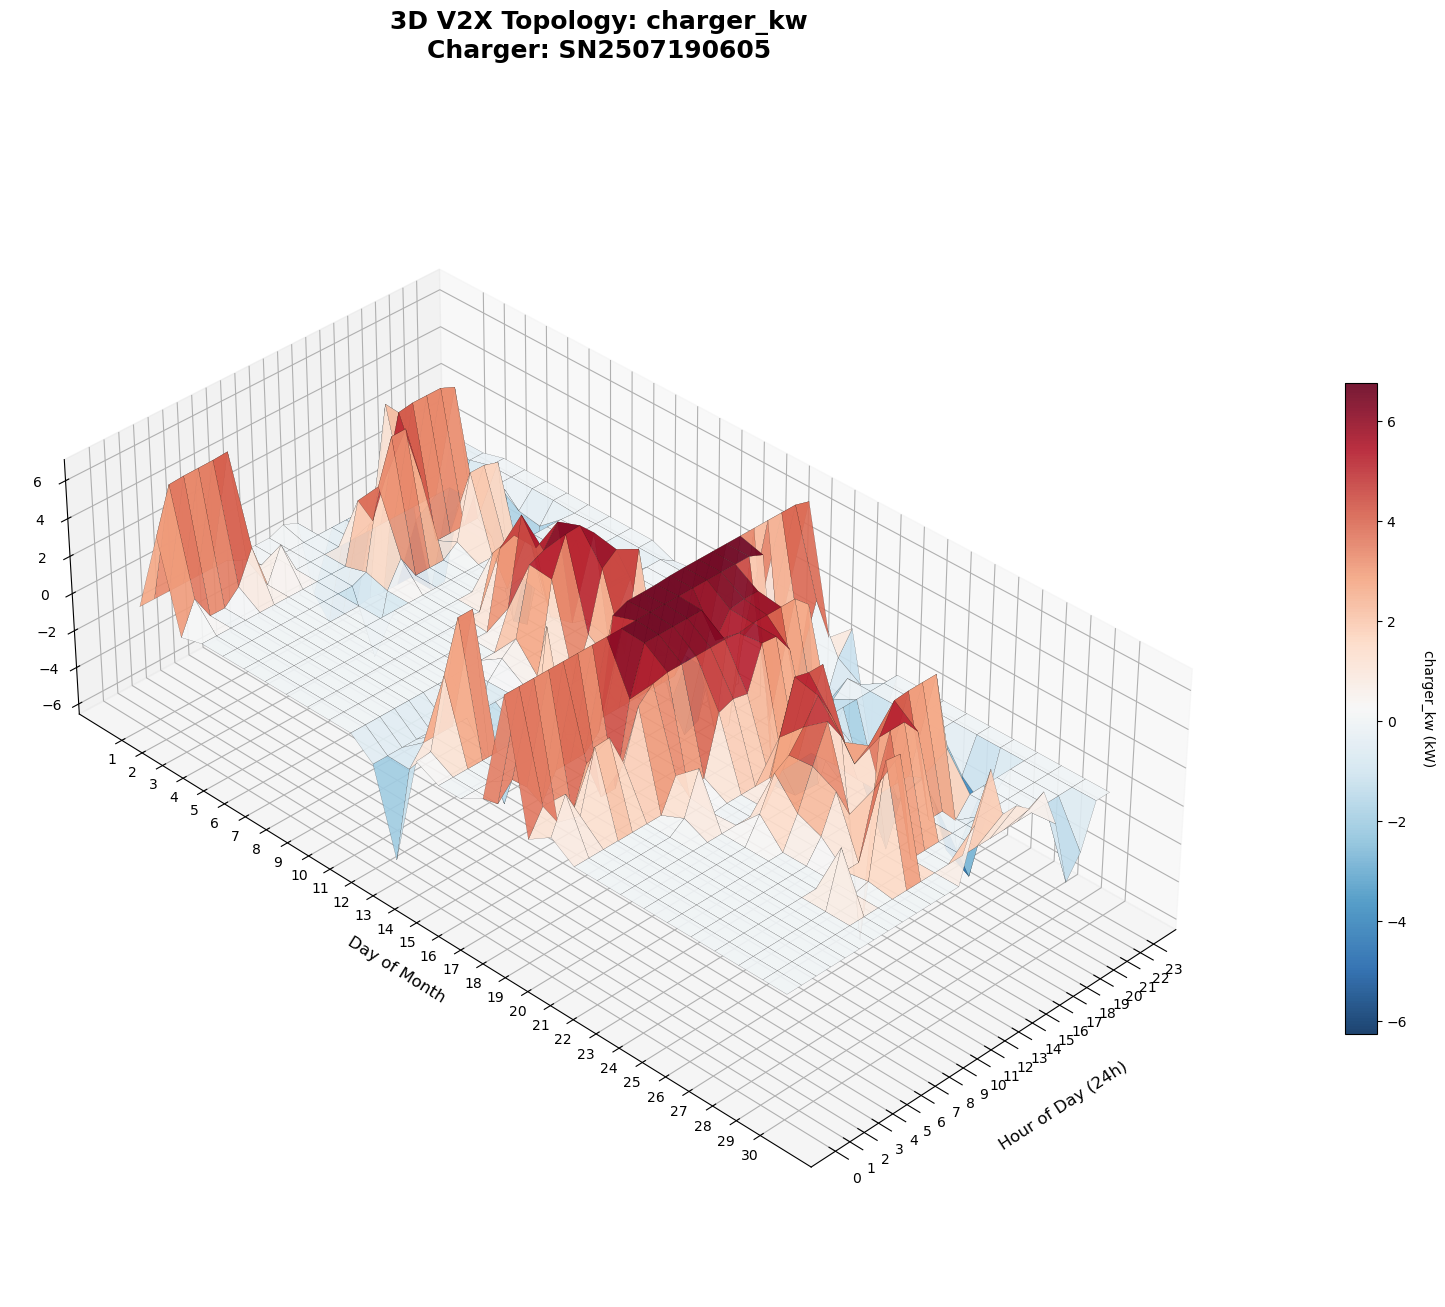

In [48]:
from mpl_toolkits.mplot3d import Axes3D

# --- SETTINGS: CHANGE THESE TO PLOT DIFFERENT DATA ---
TARGET_METRIC = 'charger_kw'    # Options: 'soc_percent', 'solar_kw', 'grid_kw', 'import_price_kwh'
METRIC_UNIT = 'kW'              # Units for the Z-axis label
COLOR_MAP = 'RdBu_r'            # Use 'viridis' for SoC/Solar, 'RdBu_r' for Power/Grid

# -----------------------------------------------------

# 1. Filter for one charger
target_id = df['systemId'].unique()[0]
df_target = df[df['systemId'] == target_id].copy()
df_target['day_num'] = df_target.index.day

# 2. Prepare the 3D Coordinate Grid
pivot_3d = df_target.pivot_table(index='hour', columns='day_num', values=TARGET_METRIC).fillna(0)

X_hours = pivot_3d.index.values
Y_days = pivot_3d.columns.values
X, Y = np.meshgrid(X_hours, Y_days)
Z_data = pivot_3d.values.T 

# 3. Initialize 3D Plot
fig = plt.figure(figsize=(16, 22)) 
ax = fig.add_subplot(111, projection='3d')

# 4. Apply your requested 'Flip' and 'Stretch'
ax.invert_yaxis()             # Chronological order
ax.set_box_aspect((1, 2, 0.6)) # Long Day axis

# 5. Plot the Surface
surf = ax.plot_surface(X, Y, Z_data, cmap=COLOR_MAP, edgecolor='k', 
                       linewidth=0.1, alpha=0.9, antialiased=True)

# 6. Precise Ticks
ax.set_xticks(np.arange(0, 24)) # 24 ticks for hours
ax.set_yticks(Y_days)           # Ticks for every day

# 7. Labels & Titles
ax.set_xlabel('Hour of Day (24h)', fontsize=12, labelpad=15)
ax.set_ylabel('Day of Month', fontsize=12, labelpad=15)
ax.set_zlabel(f'{TARGET_METRIC} ({METRIC_UNIT})', fontsize=12, labelpad=15)

ax.set_title(f"3D V2X Topology: {TARGET_METRIC}\nCharger: {target_id}", 
             fontsize=18, fontweight='bold', pad=45)

# 8. Add Colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.3, aspect=20, pad=0.1)
cbar.set_label(f'{TARGET_METRIC} ({METRIC_UNIT})', rotation=270, labelpad=20)

# 9. Set the perspective
ax.view_init(elev=35, azim=-135)

plt.tight_layout()
plt.show()

# RQ1.2. How much financial benefit do customers get from V2G?

In [81]:
def run_integrated_finance(df, driver, threshold, target_id, month_str):
    """
    Generates a 3-panel dashboard: 
    1. Cumulative ROI 
    2. Mirrored Price context with Spikes
    3. Categorical breakdown
    """
    # 1. Base Financial Calculations ($)
    # v2g_income: negated export because negative in CSV = credit/income
    df['v2g_income_$'] = (df['v2g_kw'] / 60) * (-df['export_price_kwh'] / 100)
    df['v2h_savings_$'] = (df['v2h_kw'] / 60) * (df['import_price_kwh'] / 100)
    df['g2v_cost_$'] = (df['g2v_kw'] / 60) * (df['import_price_kwh'] / 100)
    
    # 2. Spike Determination
    if driver == 'export_price_kwh':
        df['is_spike'] = (-df['export_price_kwh']) > threshold
    else:
        df['is_spike'] = df['import_price_kwh'] > threshold
        
    # 3. Monthly Aggregates
    v2g_reg = df[~df['is_spike']]['v2g_income_$'].sum()
    v2g_spike = df[df['is_spike']]['v2g_income_$'].sum()
    v2h_save = df['v2h_savings_$'].sum()
    g2v_cost = df['g2v_cost_$'].sum()
    net = (v2g_reg + v2g_spike + v2h_save) - g2v_cost

    # 4. Trend Data for Cumulative Plot
    df['net_daily_benefit'] = df['v2g_income_$'] + df['v2h_savings_$'] - df['g2v_cost_$']
    daily_cum = df['net_daily_benefit'].resample('D').sum().cumsum()

    # --- PLOTTING ---
    fig = plt.figure(figsize=(16, 10))
    # Layout: 2 rows, 2 columns. Left column is wider (2.5:1 ratio)
    gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[3, 1])
    
    # PANEL A: Cumulative Net Profit/Loss (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(daily_cum.index, daily_cum.values, color='#2c3e50', lw=3, marker='o', markersize=4, label='Net Profit')
    ax1.fill_between(daily_cum.index, 0, daily_cum.values, color='#2c3e50', alpha=0.1)
    ax1.axhline(0, color='black', linewidth=1, linestyle='--')
    ax1.set_title(f"Cumulative V2X Financial Benefit ({month_str})", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Cumulative Value ($ AUD)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')

    # PANEL B: Mirrored Price Plot (Bottom Left)
    # This shares the X-axis with the cumulative plot for easy alignment
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(df.index, df['import_price_kwh'], color='#f39c12', lw=1, alpha=0.8, label='Import Price (Cost)')
    ax2.plot(df.index, df['export_price_kwh'], color='#3498db', lw=1, alpha=0.8, label='Export Price (Credit)')
    
    # Mark Spike Events with Red Dots
    spike_indices = df[df['is_spike']].index
    if not spike_indices.empty:
        spike_prices = df.loc[spike_indices, driver]
        ax2.scatter(spike_indices, spike_prices, color='red', s=15, zorder=5, label='Price Spike')
    
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_title(f"Grid Price Context (Spikes marked where {driver} > {threshold}c)", fontsize=14)
    ax2.set_ylabel("Price (c/kWh)", fontsize=12)
    ax2.set_xlabel("Date", fontsize=12)
    ax2.legend(loc='lower left', fontsize=9)
    ax2.grid(True, alpha=0.2)

    # PANEL C: Impact Breakdown (Right Column)
    ax3 = fig.add_subplot(gs[:, 1])
    labels = ['V2G\n(Regular)', 'V2G\n(Spike)', 'V2H\n(Savings)', 'G2V\n(Cost)']
    values = [v2g_reg, v2g_spike, v2h_save, -g2v_cost]
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6']
    
    bars = ax3.bar(labels, values, color=colors)
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_title(f"Monthly Impact Breakdown\nNet: ${net:.2f}", fontsize=15, fontweight='bold', pad=20)
    ax3.set_ylabel("Total Value ($ AUD)", fontsize=12)
    
    # Add currency labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, yval + (0.5 if yval > 0 else -1.5), 
                 f'${abs(yval):.2f}', ha='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Manual Inputs for price spike

### Based on import price (as AUD3)

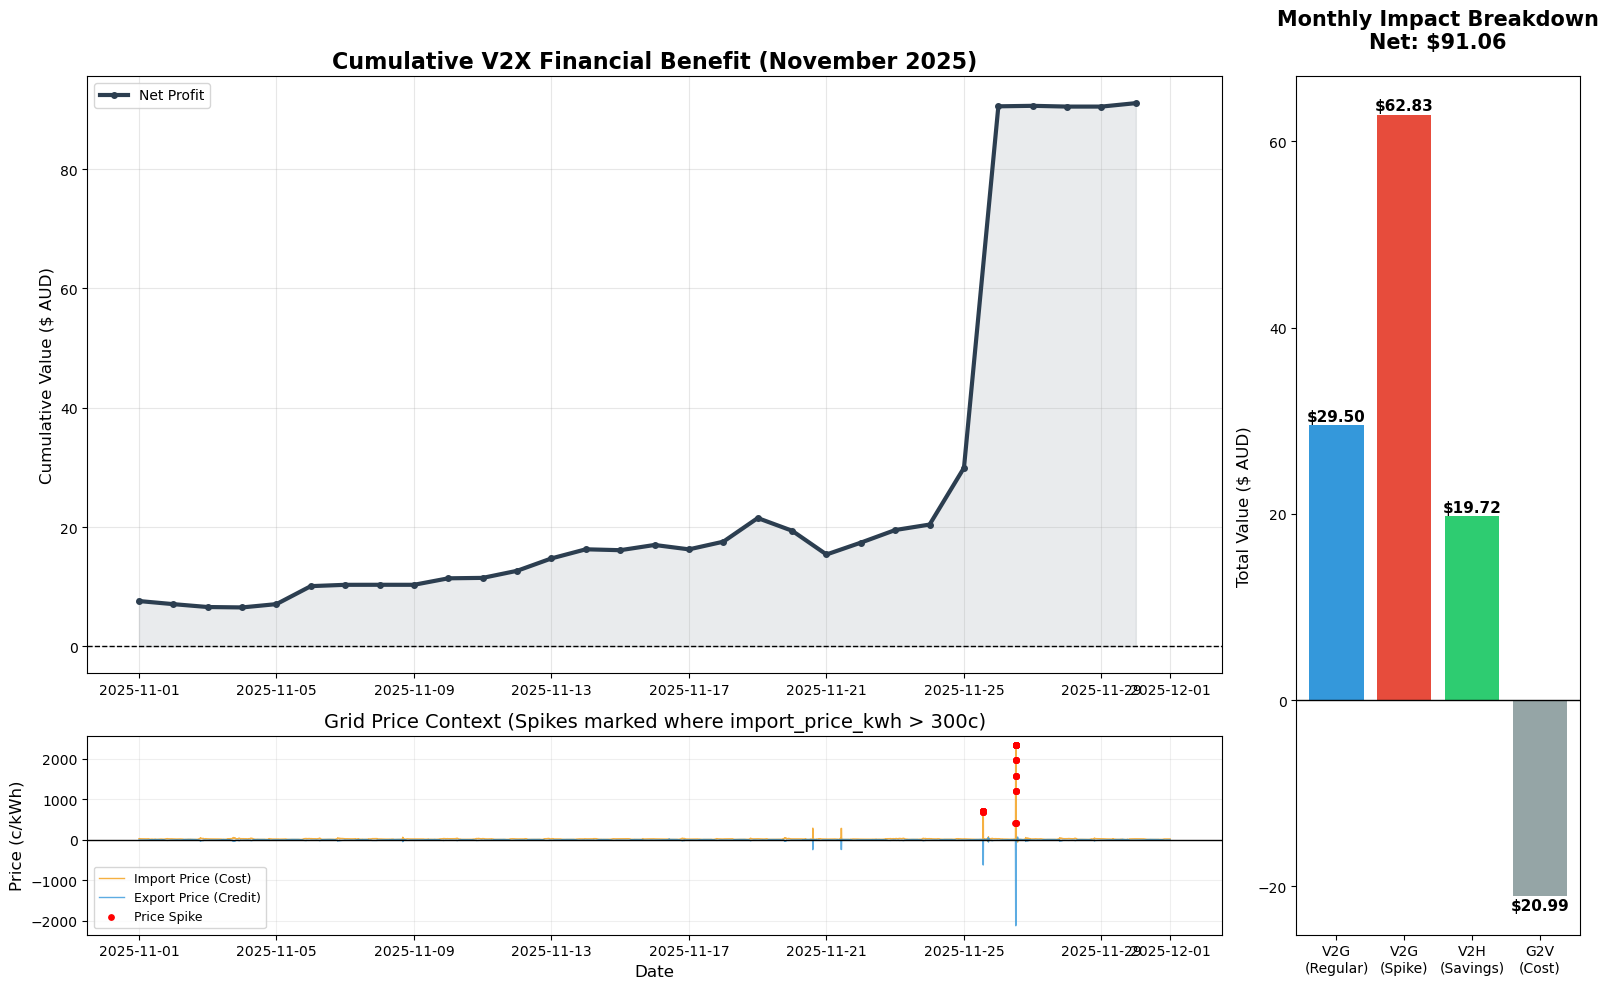

In [82]:
# --- SETTINGS: CONFIGURABLE FINANCIAL ANALYSIS ---
PRICE_DRIVER = 'import_price_kwh'  # Options: 'export_price_kwh' or 'import_price_kwh'
SPIKE_THRESHOLD_CENTS = 300        # Manually set spike threshold
# ------------------------------------------------

run_integrated_finance(df, PRICE_DRIVER, SPIKE_THRESHOLD_CENTS, target_id, month_str)

### Based on export price (arbitrary 40c)

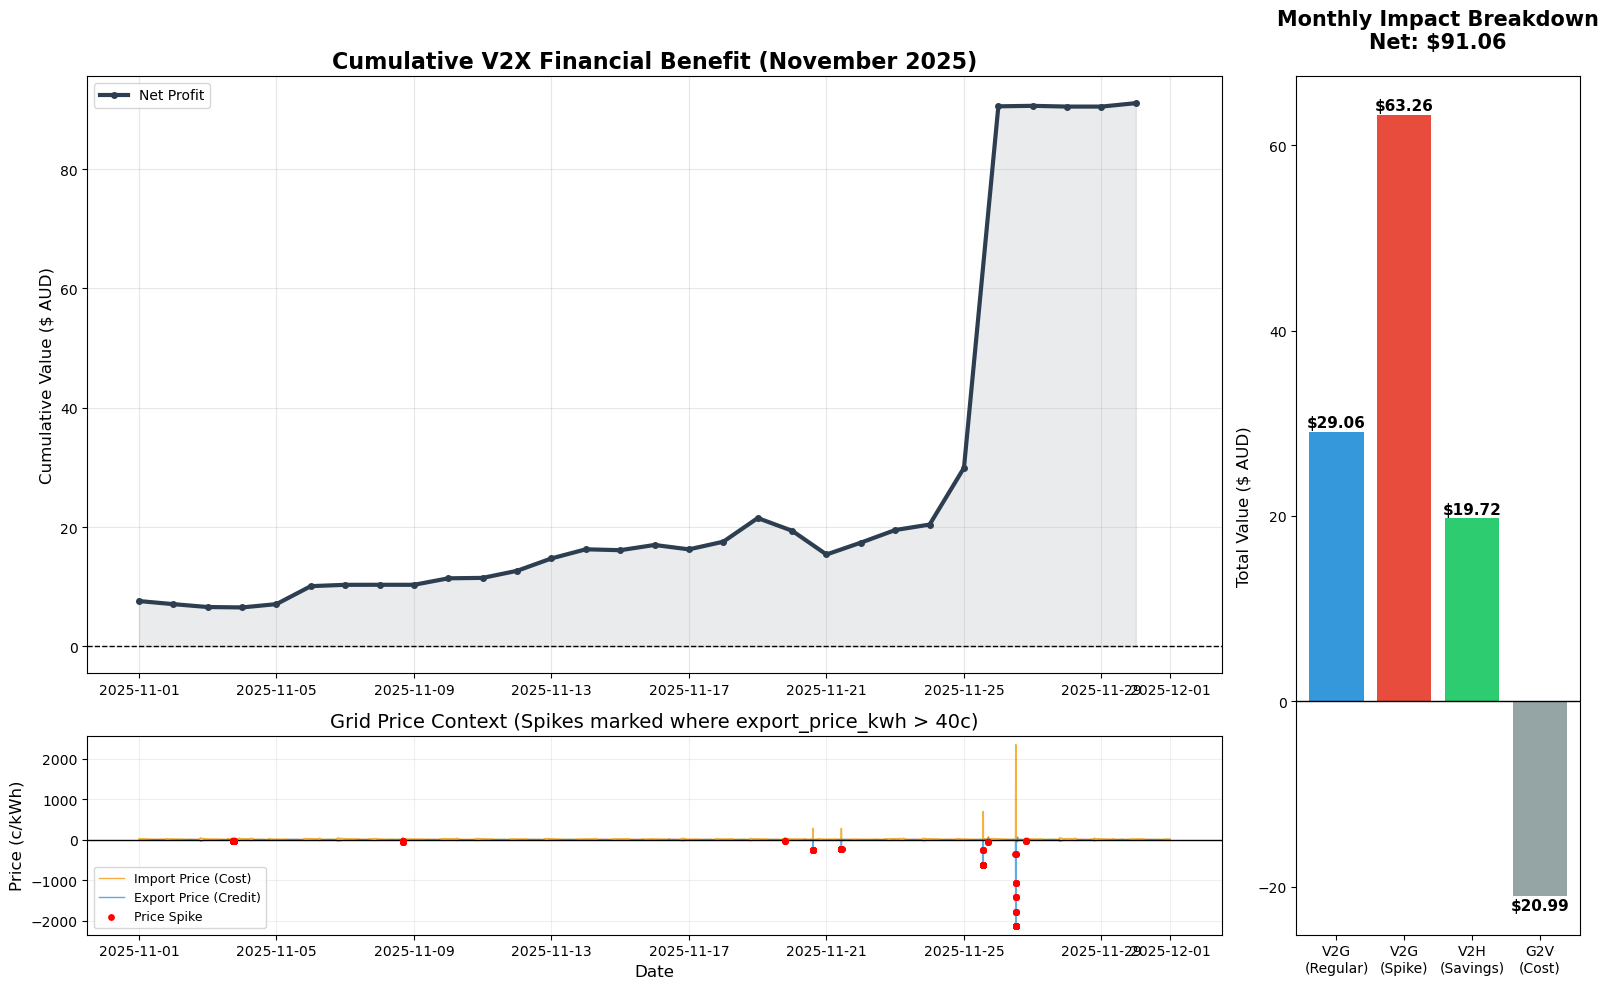

In [83]:
# --- SETTINGS: CONFIGURABLE FINANCIAL ANALYSIS ---
PRICE_DRIVER = 'export_price_kwh'  # Options: 'export_price_kwh' or 'import_price_kwh'
SPIKE_THRESHOLD_CENTS = 40        # Manually set spike threshold
# ------------------------------------------------

run_integrated_finance(df, PRICE_DRIVER, SPIKE_THRESHOLD_CENTS, target_id, month_str)

## Derived spike threshold

In [84]:
# --- PRICE SPIKE STATISTICAL ANALYSIS ---

def suggest_spike_thresholds(df):
    # Convert Export Price to positive credit for easier analysis
    export_credits = -df['export_price_kwh']
    import_costs = df['import_price_kwh']
    
    metrics = {
        'Metric': ['Average', '95th Percentile', '99th Percentile', 'Max Value'],
        'Export Credit (c/kWh)': [
            export_credits.mean(), 
            export_credits.quantile(0.95), 
            export_credits.quantile(0.99), 
            export_credits.max()
        ],
        'Import Cost (c/kWh)': [
            import_costs.mean(), 
            import_costs.quantile(0.95), 
            import_costs.quantile(0.99), 
            import_costs.max()
        ]
    }
    
    stats_df = pd.DataFrame(metrics).round(2)
    
    print("--- PRICE LANDSCAPE SUMMARY ---")
    print(stats_df.to_string(index=False))
    
    # Recommendation Logic
    rec_export = stats_df.iloc[2, 1] # 99th Percentile
    rec_import = stats_df.iloc[2, 2] # 99th Percentile
    
    print("\n--- SUGGESTION ---")
    print(f"Based on the 99th percentile (Top 1% of events):")
    print(f"-> Use {rec_export}c as EXPORT threshold.")
    print(f"-> Use {rec_import}c as IMPORT threshold.")
    print("Events above these levels represent significant grid stress.")

suggest_spike_thresholds(df)

--- PRICE LANDSCAPE SUMMARY ---
         Metric  Export Credit (c/kWh)  Import Cost (c/kWh)
        Average                   8.59                15.13
95th Percentile                  19.90                25.23
99th Percentile                  27.71                34.17
      Max Value                2123.33              2343.31

--- SUGGESTION ---
Based on the 99th percentile (Top 1% of events):
-> Use 27.71c as EXPORT threshold.
-> Use 34.17c as IMPORT threshold.
Events above these levels represent significant grid stress.


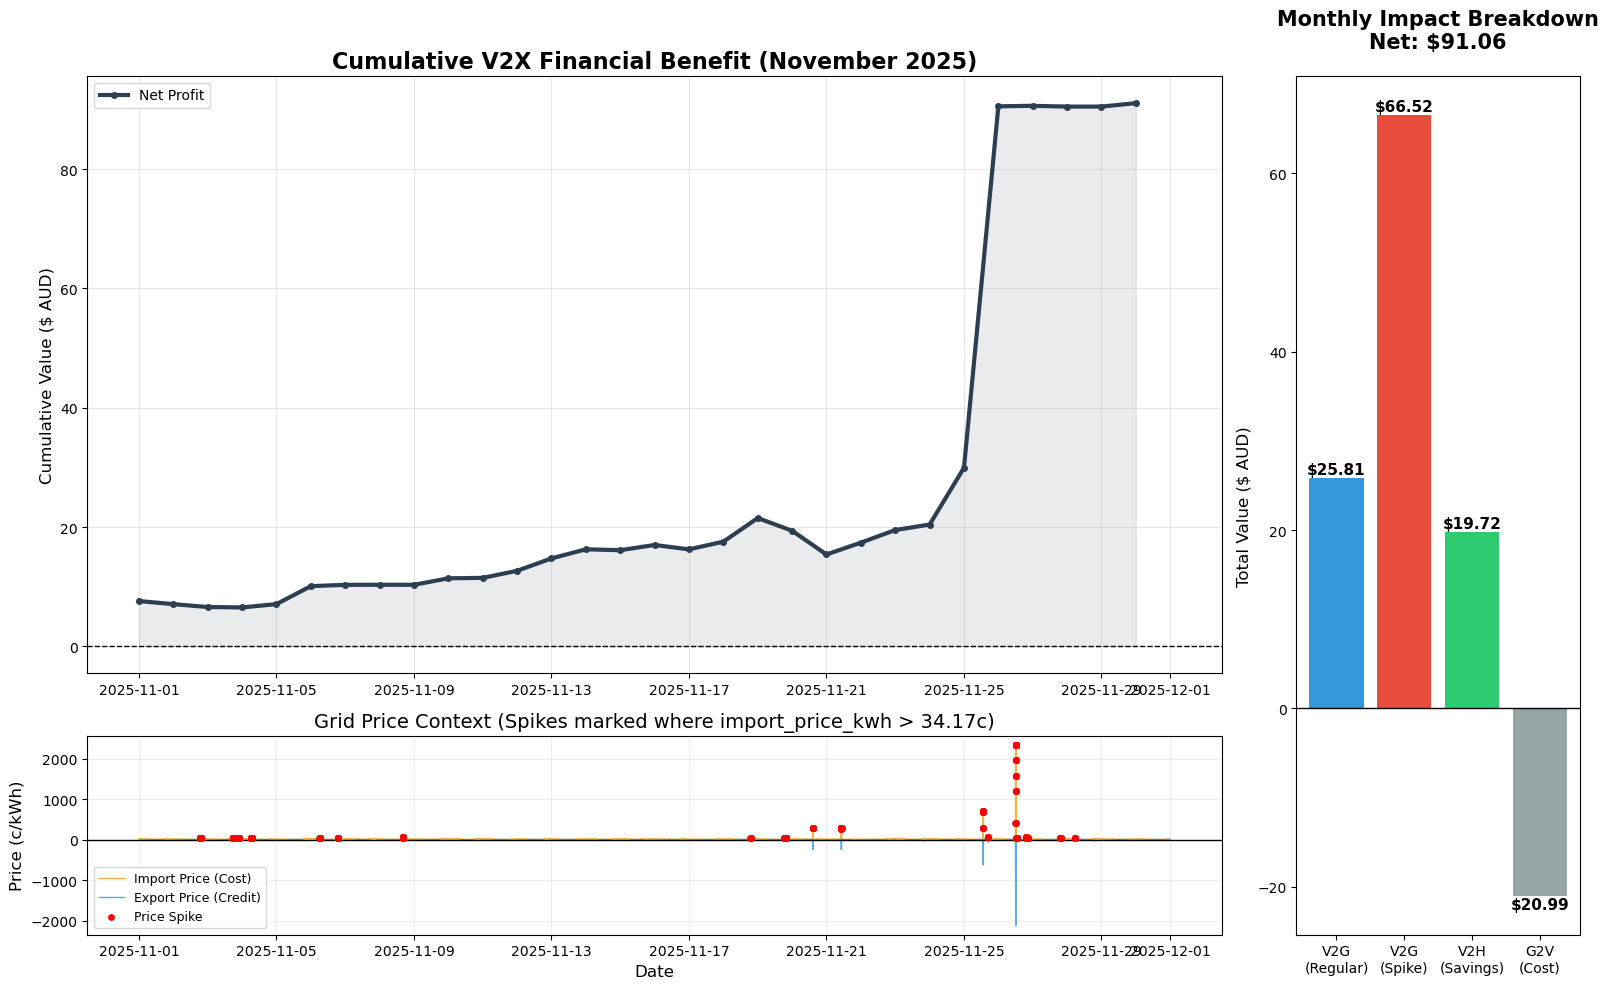

In [87]:
# --- SETTINGS: CONFIGURABLE FINANCIAL ANALYSIS ---
PRICE_DRIVER = 'import_price_kwh'  # Options: 'export_price_kwh' or 'import_price_kwh'
SPIKE_THRESHOLD_CENTS = 34.17        # Manually set spike threshold
# ------------------------------------------------

run_integrated_finance(df, PRICE_DRIVER, SPIKE_THRESHOLD_CENTS, target_id, month_str)

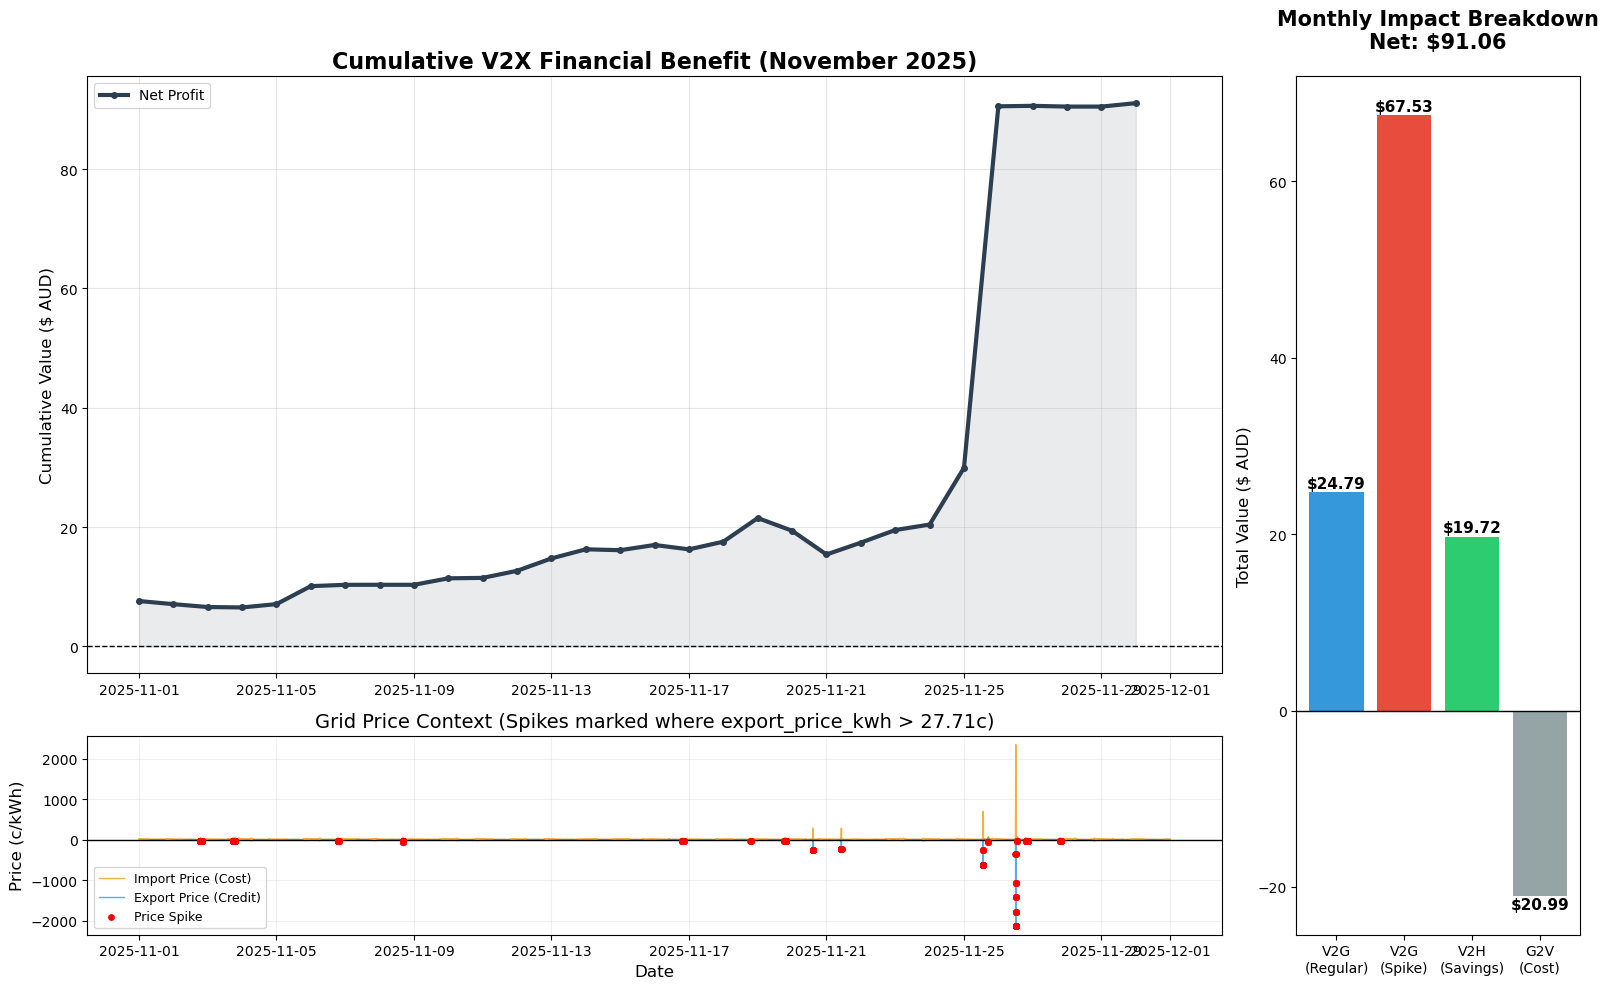

In [88]:
# --- SETTINGS: CONFIGURABLE FINANCIAL ANALYSIS ---
PRICE_DRIVER = 'export_price_kwh'  # Options: 'export_price_kwh' or 'import_price_kwh'
SPIKE_THRESHOLD_CENTS = 27.71        # Manually set spike threshold
# ------------------------------------------------

run_integrated_finance(df, PRICE_DRIVER, SPIKE_THRESHOLD_CENTS, target_id, month_str)

# RQ1.3.